# Experiments with KAN Integration

## Install Necessary Libraries

In [ ]:
# Install necessary libraries
!pip install python-chess tensorflow numpy pandas matplotlib seaborn pyyaml ipywidgets torch scikit-learn

# Ensure ipywidgets is enabled
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py --sys-prefix ipywidgets

# Remove the existing pykan directory if it exists
import shutil
import os

if os.path.exists('pykan'):
    shutil.rmtree('pykan')

# Clone the pykan repository
!git clone https://github.com/KindXiaoming/pykan

# Change directory to pykan and install it
!pip install ./pykan




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 126.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 62.9 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/local/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
   

# Experiment 1: Minimax Kane And Its Randomization Integrated with KAN

## Step 1: Overall Design
### Objective:
To integrate the Kolmogorov-Arnold Networks (KAN) model to analyze and interpret the equivalence between deterministic and randomized versions of a Minimax algorithm-based chess AI named Kane.

### Steps:
**Minimax Implementation:**

- Implement the deterministic version of the Minimax algorithm with heuristic evaluation for Kane.
- Introduce randomization to the evaluation function and move selection to create a randomized version.
**Game Simulation:**

- Simulate games using both the deterministic and randomized versions of Kane.
- Collect performance metrics during each game, including additional metrics like evaluation score, branching factor, depth of search, move diversity, and exploration vs. exploitation.
**Data Collection and Analysis:**

- Collect and aggregate the performance metrics from multiple games.
- Compare the aggregated metrics between the deterministic and randomized versions.
- Plot comparison metrics and equivalence curves to visualize the relationship.
**KAN Model Integration:**

- Define a custom KAN model architecture using PyTorch.
- Train the KAN model on the aggregated data from both deterministic and randomized versions.
- Evaluate the model's performance and track the equivalence score during training.
**Visualization:**
- Visualize the dataset.
- Extract and visualize the symbolic formula from the trained KAN model.
- Plot the model's structure and equivalence data points.
- Visualize the weights and biases of the trained KAN model.
**Statistical Analysis:**

- Perform statistical tests (t-test and F-test) to validate the results.
- Plot the results of the statistical analysis.
**Implementation:**
- Implement the KAN model using the provided KAN library.
- Train the KAN model with the training data from the deterministic and randomized versions.
- Calculate the equivalence score during each epoch of training.
- Use matplotlib for plotting and visualizing the results.

## Step 2: Minimax Implementation with Randomization for Kane
### 2.1: Deterministic Minimax Implementation

In [ ]:
import chess
from collections import defaultdict

# Deterministic Minimax Implementation
class KaneMinimaxDeterministic:
    def __init__(self, board):
        self.board = board
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())

        # Simplified scoring, can be improved with a better piece-square table
        score = material_count + mobility_count + piece_square_score + center_control_count
        return score

    def minimax(self, board, depth, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.minimax_search(board, depth, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def minimax_search(self, board, depth, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, False)
                board.pop()
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, True)
                board.pop()
                min_eval = min(min_eval, eval)
            return min_eval

    def find_best_move_minimax(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.minimax(self.board, depth, False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


### 2.2: Introduce Randomization to the Evaluation Function and Move Selection

In [ ]:
# Pseudorandom Generator (PRG)
class PseudoRandom:
    def __init__(self, seed):
        self.state = seed

    def random(self):
        self.state = (1103515245 * self.state + 12345) % (2**31)
        return self.state / (2**31)

# Randomized Evaluation Function
class KaneMinimaxRandomization:
    def __init__(self, board, seed):
        self.board = board
        self.prng = PseudoRandom(seed)
        self.evaluation_consistency = defaultdict(list)
        self.move_stability = defaultdict(int)
        self.search_paths = defaultdict(list)

    def heuristic_evaluation(self, board):
        # Enhanced heuristic evaluation function with random component
        material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
        mobility_count = len(list(board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())

        # Simplified scoring, can be improved with a better piece-square table
        score = material_count + mobility_count + piece_square_score + center_control_count

        # Random adjustment
        random_adjustment = int((self.prng.random() - 0.5) * 10)  # Random adjustment between -5 and +5
        return score + random_adjustment

    def minimax(self, board, depth, is_maximizing_player):
        position_hash = hash(board.board_fen())
        if position_hash in self.evaluation_consistency and depth == 0:
            return self.evaluation_consistency[position_hash][-1]  # Return the last stored evaluation for consistency
        
        evaluation = self.heuristic_evaluation(board) if depth == 0 or board.is_game_over() else (
            self.minimax_search(board, depth, is_maximizing_player)
        )
        self.evaluation_consistency[position_hash].append(evaluation)
        return evaluation

    def minimax_search(self, board, depth, is_maximizing_player):
        if is_maximizing_player:
            max_eval = float('-inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, False)
                board.pop()
                max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for move in board.legal_moves:
                board.push(move)
                eval = self.minimax(board, depth - 1, True)
                board.pop()
                min_eval = min(min_eval, eval)
            return min_eval

    def find_best_move_minimax(self, depth=3):
        position_hash = hash(self.board.board_fen())
        best_move = None
        best_value = float('-inf')
        for move in self.board.legal_moves:
            self.board.push(move)
            move_value = self.minimax(self.board, depth, False)
            self.board.pop()
            if move_value > best_value:
                best_value = move_value
                best_move = move
        self.move_stability[position_hash] += 1
        return best_move

    def track_search_path(self, board, move):
        position_hash = hash(board.board_fen())
        self.search_paths[position_hash].append(move.uci())


### Step 3: Simulate Games Using Both Deterministic and Randomized Algorithms
### 3.1: Helper Functions for Metrics Calculation

In [ ]:
import time
import pandas as pd
from IPython.display import clear_output, display, SVG
import chess.svg
import numpy as np

# Function to calculate additional metrics
def calculate_metrics(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())  # Simplified for demonstration
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    return material_count, mobility_count, piece_square_score, center_control_count

def calculate_additional_metrics(board, move_scores, current_depth, is_exploratory):
    evaluation_score = sum(move_scores) / len(move_scores) if move_scores else 0
    branching_factor = len(list(board.legal_moves))
    depth_of_search = current_depth
    move_diversity = np.var(move_scores) if move_scores else 0
    exploration_vs_exploitation = 1 if is_exploratory else 0
    return evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation


### 3.2: Function to Play the Game with Deterministic Minimax

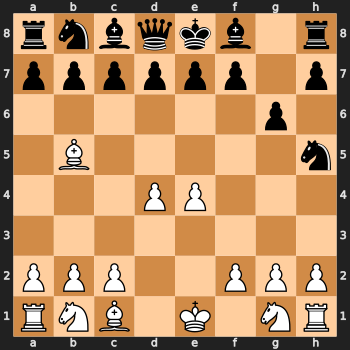

Move: d2d4
Step: 8, Time: 54.63199853897095, Material: -1, Mobility: 20, Piece-Square: -1, Center Control: 2
Stop the game in advance!
Result: *
   Step       Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1  27.001452  e2e4               0              20                   0   
1     2  52.730195  g8f6               0              30                   0   
2     3  63.085925  f1b5               0              19                   0   
3     4  52.671453  g7g6               0              34                   0   
4     5  66.732161  d1h5               0              20                   0   
5     6  93.544883  f6h5              -1              31                  -1   
6     7  54.631999  d2d4              -1              20                  -1   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              37.0                20                3   
1                     1               8.0             

In [ ]:
# Function to play the game with deterministic Minimax
def play_game_minimax_deterministic(kane_minimax, depth=3, max_moves=55, max_runtime=600):
    steps = []
    times = []
    material_counts = []
    mobility_counts = []
    piece_square_scores = []
    center_control_counts = []
    move_list = []
    evaluation_scores = []
    branching_factors = []
    depths_of_search = []
    move_diversities = []
    exploration_vs_exploitations = []
    step_number = 1

    start_time = time.time()
    while not kane_minimax.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_minimax.find_best_move_minimax(depth)
        move_end_time = time.time()

        kane_minimax.board.push(best_move)
        kane_minimax.track_search_path(kane_minimax.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        # Calculate metrics
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_minimax.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        # Collect additional metrics
        move_scores = [kane_minimax.minimax(kane_minimax.board, depth, False) for move in kane_minimax.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_minimax.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_minimax.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    # Create a DataFrame for the collected data
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_minimax.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneMinimaxDeterministic(board_deterministic)

# Simulate and run the deterministic game
print("Running deterministic game...")
deterministic_results = [play_game_minimax_deterministic(kane_deterministic)]


### 3.3: Function to Play the Game with Randomized Minimax

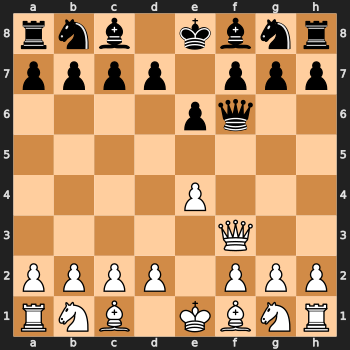

Move: d8f6
Step: 5, Time: 150.16789269447327, Material: 0, Mobility: 38, Piece-Square: 0, Center Control: 1
Stop the game in advance!
Result: *
   Step        Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1   26.892736  e2e4               0              20                   0   
1     2   51.882389  e7e6               0              30                   0   
2     3  102.766409  d1f3               0              30                   0   
3     4  150.167893  d8f6               0              38                   0   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              35.0                20                3   
1                     1              10.0                30                3   
2                     1              29.0                30                3   
3                     1              23.0                38                3   

   Move Diversity  Exploration vs Exploitation  


In [ ]:
# Function to play the game with randomized Minimax
def play_game_minimax_randomized(kane_minimax, depth=3, max_moves=55, max_runtime=600):
    steps = []
    times = []
    material_counts = []
    mobility_counts = []
    piece_square_scores = []
    center_control_counts = []
    move_list = []
    evaluation_scores = []
    branching_factors = []
    depths_of_search = []
    move_diversities = []
    exploration_vs_exploitations = []
    step_number = 1

    start_time = time.time()
    while not kane_minimax.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        best_move = kane_minimax.find_best_move_minimax(depth)
        move_end_time = time.time()

        kane_minimax.board.push(best_move)
        kane_minimax.track_search_path(kane_minimax.board, best_move)

        move_list.append(best_move.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)

        # Calculate metrics
        material_count, mobility_count, piece_square_score, center_control_count = calculate_metrics(kane_minimax.board)
        material_counts.append(material_count)
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)

        # Collect additional metrics
        move_scores = [kane_minimax.minimax(kane_minimax.board, depth, False) for move in kane_minimax.board.legal_moves]
        evaluation_score, branching_factor, depth_of_search, move_diversity, exploration_vs_exploitation = calculate_additional_metrics(
            kane_minimax.board, move_scores, depth, False)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)

        step_number += 1

        clear_output(wait=True)
        display(SVG(chess.svg.board(board=kane_minimax.board, size=350)))

        time.sleep(1)
        print(f"Move: {best_move}")
        print(f"Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {material_count}, Mobility: {mobility_count}, Piece-Square: {piece_square_score}, Center Control: {center_control_count}")

    # Create a DataFrame for the collected data
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)

    print("Stop the game in advance!")
    print(f"Result: {kane_minimax.board.result()}")
    print(df)
    return df

# Initialize the boards and engines
board_randomized = chess.Board()
kane_randomized = KaneMinimaxRandomization(board_randomized, seed=42)

# Simulate and run the randomized game
print("Running randomized game...")
randomized_results = [play_game_minimax_randomized(kane_randomized)]


## Step 4: Collect and Analyze Performance Metrics
### 4.1: Collect Evaluation Consistency Data

In [ ]:
# Collect evaluation consistency data
evaluation_consistency_df = pd.DataFrame.from_dict(kane_deterministic.evaluation_consistency, orient='index').transpose()
evaluation_consistency_df = evaluation_consistency_df.ffill()

# Collect move stability data
move_stability_df = pd.DataFrame.from_dict(kane_deterministic.move_stability, orient='index', columns=['Move Stability'])

# Collect search path data
search_paths_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in kane_deterministic.search_paths.items()]))

# Debugging print statements
print("Evaluation Consistency DataFrame:\n", evaluation_consistency_df.head())
print("Move Stability DataFrame:\n", move_stability_df.head())
print("Search Paths DataFrame:\n", search_paths_df.head())


Evaluation Consistency DataFrame:
     2590928384027264515   5933354859821168365  -827133136056076540   \
0                  25.0                  25.0                  25.0   
1                  25.0                  25.0                  25.0   
2                  25.0                  25.0                  25.0   
3                  25.0                  25.0                  25.0   
4                  25.0                  25.0                  25.0   

    5621271814311429045  -695240252472641569    8915702355095411780  \
0                  25.0                  25.0                  24.0   
1                  25.0                  25.0                  24.0   
2                  25.0                  25.0                  24.0   
3                  25.0                  25.0                  24.0   
4                  25.0                  25.0                  24.0   

   -3293981075952575725   459105686222666227   -7376713270076502300  \
0                  25.0                 

### 4.2: Ensure Results are DataFrames and Aggregate Metrics

In [ ]:
# Function to ensure all results are DataFrames and handle errors
def ensure_dataframe(result):
    if isinstance(result, pd.DataFrame):
        return result
    try:
        return pd.DataFrame(result)
    except Exception as e:
        print("Error converting to DataFrame:", e)
        return pd.DataFrame()

# Convert results to DataFrames
deterministic_results = [ensure_dataframe(df) for df in deterministic_results]
randomized_results = [ensure_dataframe(df) for df in randomized_results]

# Print structures for debugging
print("\nDeterministic Results Sample:\n", deterministic_results[0].head() if deterministic_results else "No Data")
print("\nRandomized Results Sample:\n", randomized_results[0].head() if randomized_results else "No Data")

# Aggregate and analyze the results
def aggregate_metrics(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    
    # Ensure results is a list of DataFrame objects
    aggregated_data = pd.concat(results, ignore_index=True)
    
    # Select only numeric columns and convert them to numeric types
    numeric_data = aggregated_data[numeric_columns]
    
    # Print columns to debug
    print("\nAggregated Data Columns:\n", numeric_data.columns)
    
    mean_metrics = numeric_data.mean()
    std_metrics = numeric_data.std()
    
    return mean_metrics, std_metrics, numeric_data

# Aggregate the results
deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

# Display the aggregated metrics
print("Deterministic Mean Metrics:\n", deterministic_mean)
print("Deterministic Std Metrics:\n", deterministic_std)
print("\nRandomized Mean Metrics:\n", randomized_mean)
print("Randomized Std Metrics:\n", randomized_std)





Deterministic Results Sample:
    Step       Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1  27.001452  e2e4               0              20                   0   
1     2  52.730195  g8f6               0              30                   0   
2     3  63.085925  f1b5               0              19                   0   
3     4  52.671453  g7g6               0              34                   0   
4     5  66.732161  d1h5               0              20                   0   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     1              37.0                20                3   
1                     1               8.0                30                3   
2                     1              27.0                19                3   
3                     1               8.0                34                3   
4                     1              28.0                20                3   

   Mov

## Step 5: Compare the Deterministic and Randomized Algorithms and Generate Equivalence Curves


Aggregated Data Columns:
 Index(['Material Count', 'Mobility Count', 'Piece-Square Score',
       'Center Control Count', 'Evaluation Score', 'Branching Factor',
       'Depth of Search', 'Move Diversity', 'Exploration vs Exploitation'],
      dtype='object')

Aggregated Data Columns:
 Index(['Material Count', 'Mobility Count', 'Piece-Square Score',
       'Center Control Count', 'Evaluation Score', 'Branching Factor',
       'Depth of Search', 'Move Diversity', 'Exploration vs Exploitation'],
      dtype='object')
Deterministic Mean Metrics:
 Material Count                 -0.285714
Mobility Count                 24.857143
Piece-Square Score             -0.285714
Center Control Count            1.142857
Evaluation Score               22.571429
Branching Factor               24.857143
Depth of Search                 3.000000
Move Diversity                  0.000000
Exploration vs Exploitation     0.000000
dtype: float64
Deterministic Std Metrics:
 Material Count                  0.487

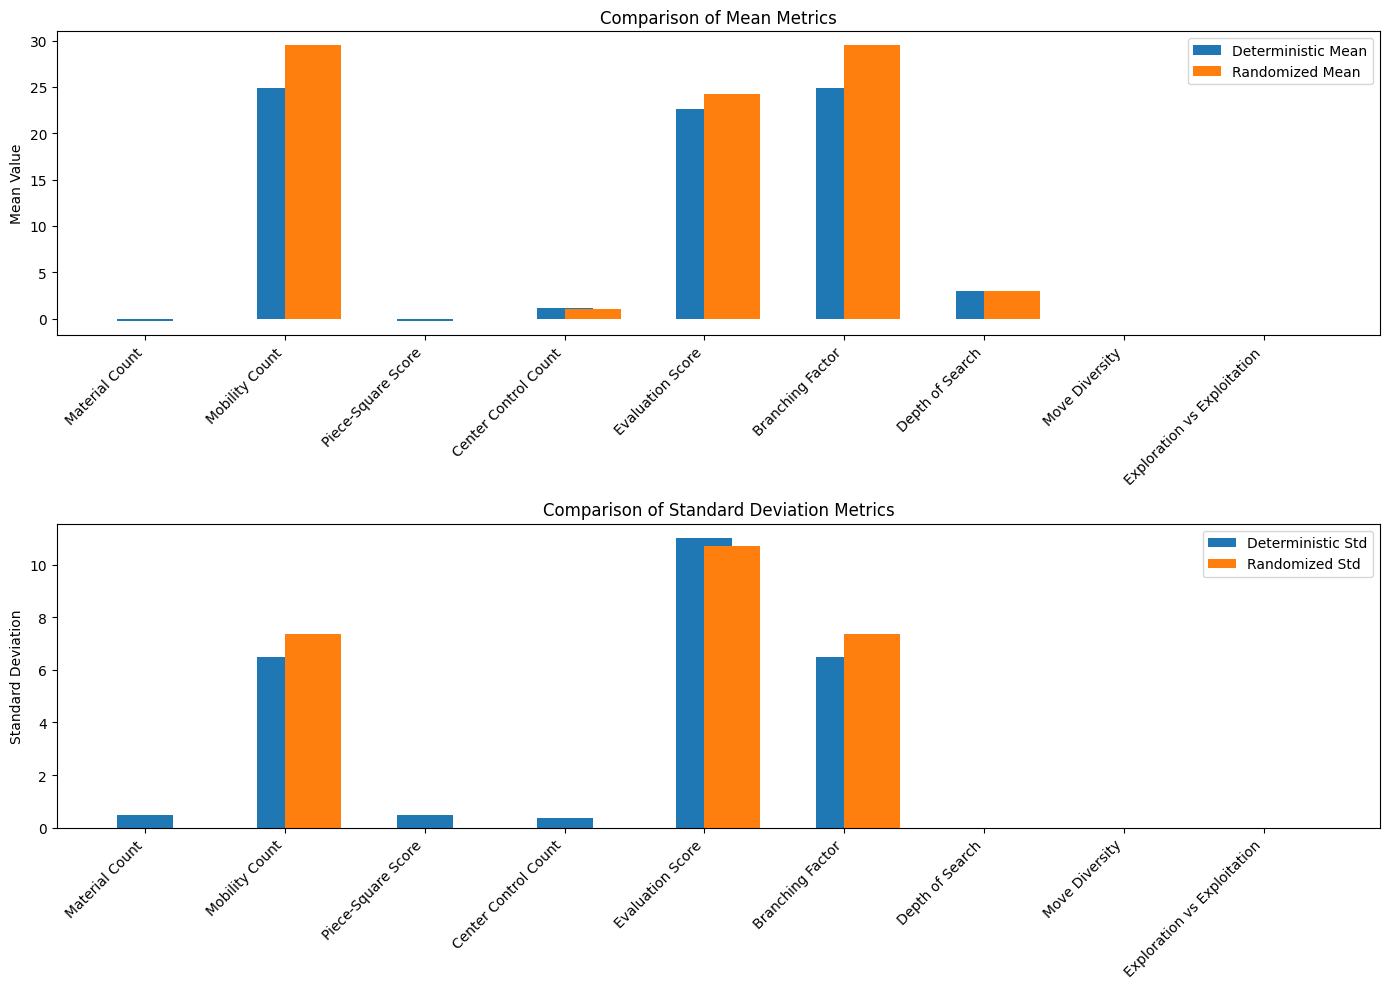

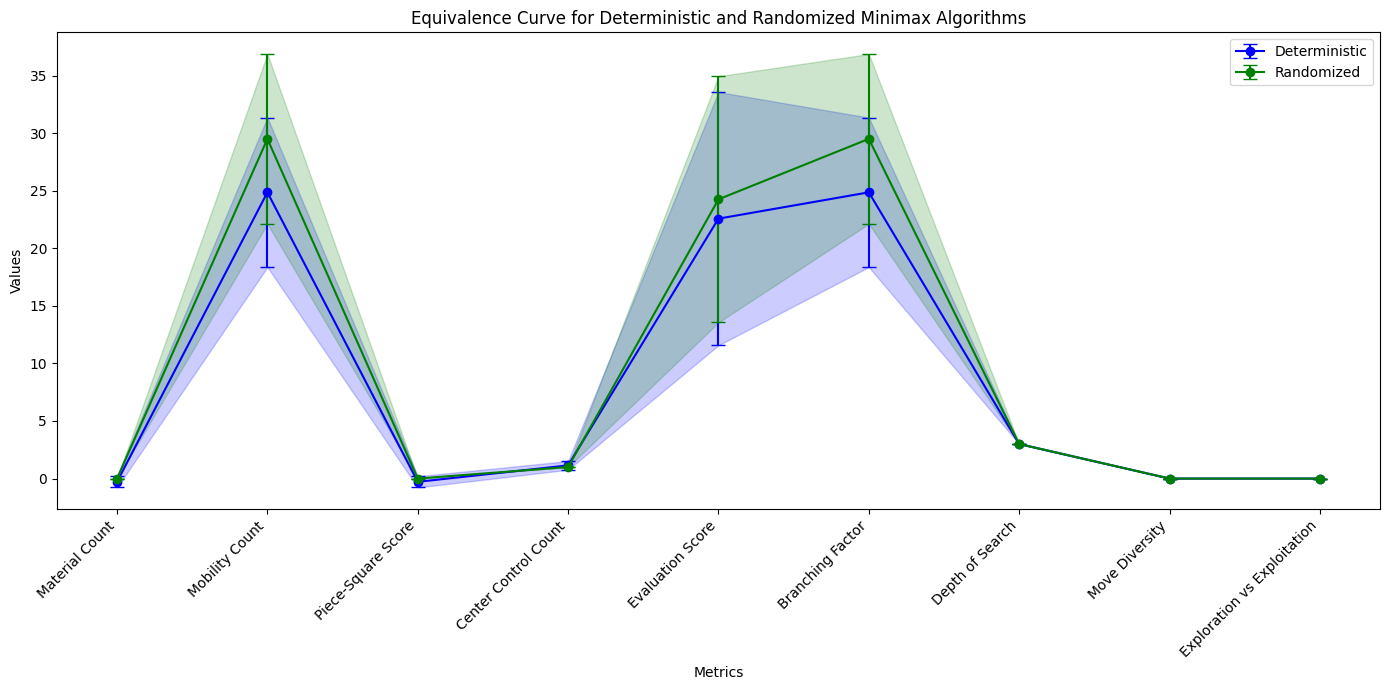

In [ ]:
import matplotlib.pyplot as plt

# Function to compare Kane versions
def compare_kane_versions(deterministic_results, randomized_results):
    deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
    randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

    # Display the aggregated metrics
    print("Deterministic Mean Metrics:\n", deterministic_mean)
    print("Deterministic Std Metrics:\n", deterministic_std)
    print("\nRandomized Mean Metrics:\n", randomized_mean)
    print("Randomized Std Metrics:\n", randomized_std)

    # Plot comparison metrics
    def plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
        metrics = deterministic_mean.index
        x = range(len(metrics))

        fig, axs = plt.subplots(2, 1, figsize=(14, 10))

        # Plot means
        axs[0].bar(x, deterministic_mean, width=0.4, label='Deterministic Mean', align='center')
        axs[0].bar(x, randomized_mean, width=0.4, label='Randomized Mean', align='edge')
        axs[0].set_xticks(x)
        axs[0].set_xticklabels(metrics, rotation=45, ha='right')
        axs[0].set_ylabel('Mean Value')
        axs[0].set_title('Comparison of Mean Metrics')
        axs[0].legend()

        # Plot standard deviations
        axs[1].bar(x, deterministic_std, width=0.4, label='Deterministic Std', align='center')
        axs[1].bar(x, randomized_std, width=0.4, label='Randomized Std', align='edge')
        axs[1].set_xticks(x)
        axs[1].set_xticklabels(metrics, rotation=45, ha='right')
        axs[1].set_ylabel('Standard Deviation')
        axs[1].set_title('Comparison of Standard Deviation Metrics')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    # Plot comparison metrics
    plot_comparison_metrics(deterministic_mean, deterministic_std, randomized_mean, randomized_std)

    # Plot equivalence curve
    def plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
        metrics = deterministic_mean.index
        x = np.arange(len(metrics))

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(14, 7))

        # Plot deterministic means with error bars for std
        ax.errorbar(x, deterministic_mean, yerr=deterministic_std, fmt='o-', label='Deterministic', color='blue', capsize=5)

        # Plot randomized means with error bars for std
        ax.errorbar(x, randomized_mean, yerr=randomized_std, fmt='o-', label='Randomized', color='green', capsize=5)

        # Fill between for deterministic std
        ax.fill_between(x, deterministic_mean - deterministic_std, deterministic_mean + deterministic_std, color='blue', alpha=0.2)

        # Fill between for randomized std
        ax.fill_between(x, randomized_mean - randomized_std, randomized_mean + randomized_std, color='green', alpha=0.2)

        # Add title and labels
        ax.set_title('Equivalence Curve for Deterministic and Randomized Minimax Algorithms')
        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, ha='right')

        # Add legend
        ax.legend()

        # Show plot
        plt.tight_layout()
        plt.show()

    # Plot equivalence curve
    plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std)

# Compare the results
compare_kane_versions(deterministic_results, randomized_results)


## Step 6: Verification and Conclusion
### 6.1: Simulate Multiple Games

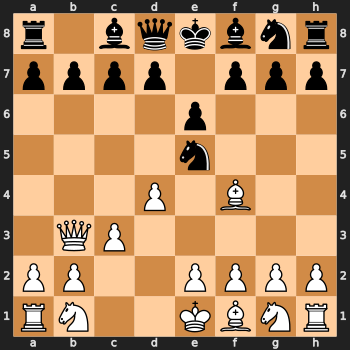

Move: c1f4
Step: 8, Time: 155.2534019947052, Material: 0, Mobility: 34, Piece-Square: 0, Center Control: 2
Stop the game in advance!
Result: *
   Step        Time  Move  Material Count  Mobility Count  Piece-Square Score  \
0     1   13.621773  c2c3               0              20                   0   
1     2   25.201166  b8c6               0              21                   0   
2     3   33.977063  d1b3               0              22                   0   
3     4   51.975408  c6e5               0              29                   0   
4     5   58.824654  d2d4               0              24                   0   
5     6   78.112448  e7e6               0              35                   0   
6     7  155.253402  c1f4               0              34                   0   

   Center Control Count  Evaluation Score  Branching Factor  Depth of Search  \
0                     0              26.0                20                3   
1                     0              10.0       

In [ ]:
def compare_kane_versions(deterministic_kane, randomized_kane, depth=3, games=3, max_moves=55, max_runtime=600):
    deterministic_results = []
    randomized_results = []

    for _ in range(games):
        # Play game with deterministic Kane
        deterministic_kane.board.reset()
        deterministic_data = play_game_minimax_deterministic(deterministic_kane, depth, max_moves, max_runtime)
        deterministic_results.append(deterministic_data)

        # Play game with randomized Kane
        randomized_kane.board.reset()
        randomized_data = play_game_minimax_randomized(randomized_kane, depth, max_moves, max_runtime)
        randomized_results.append(randomized_data)

    return deterministic_results, randomized_results

# Initialize the boards and engines
board_deterministic = chess.Board()
kane_deterministic = KaneMinimaxDeterministic(board_deterministic)

board_randomized = chess.Board()
kane_randomized = KaneMinimaxRandomization(board_randomized, seed=42)

# Compare the two versions over multiple games
deterministic_results, randomized_results = compare_kane_versions(kane_deterministic, kane_randomized)


### 6.2: Aggregate Additional Data

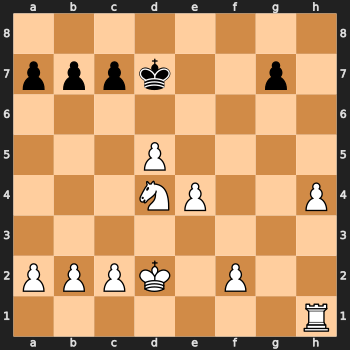

Move: b1h1
Step: 56, Time: 0.1265575885772705, Material: 5, Mobility: 13, Piece-Square: 5, Center Control: 3
Stop the game in advance!
Result: *
    Step      Time   Move  Material Count  Mobility Count  Piece-Square Score  \
0      1  0.027866   d2d3               0              20                   0   
1      2  0.037600   h7h5               0              27                   0   
2      3  0.039498   c1g5               0              20                   0   
3      4  0.134222   d7d5               0              31                   0   
4      5  0.218507   e2e4               0              29                   0   
5      6  0.271350   d8d6               0              38                   0   
6      7  0.420853   d1d2               0              44                   0   
7      8  0.403863   b8c6               0              37                   0   
8      9  0.407029   b1c3               0              43                   0   
9     10  0.445977   c6d4               0    

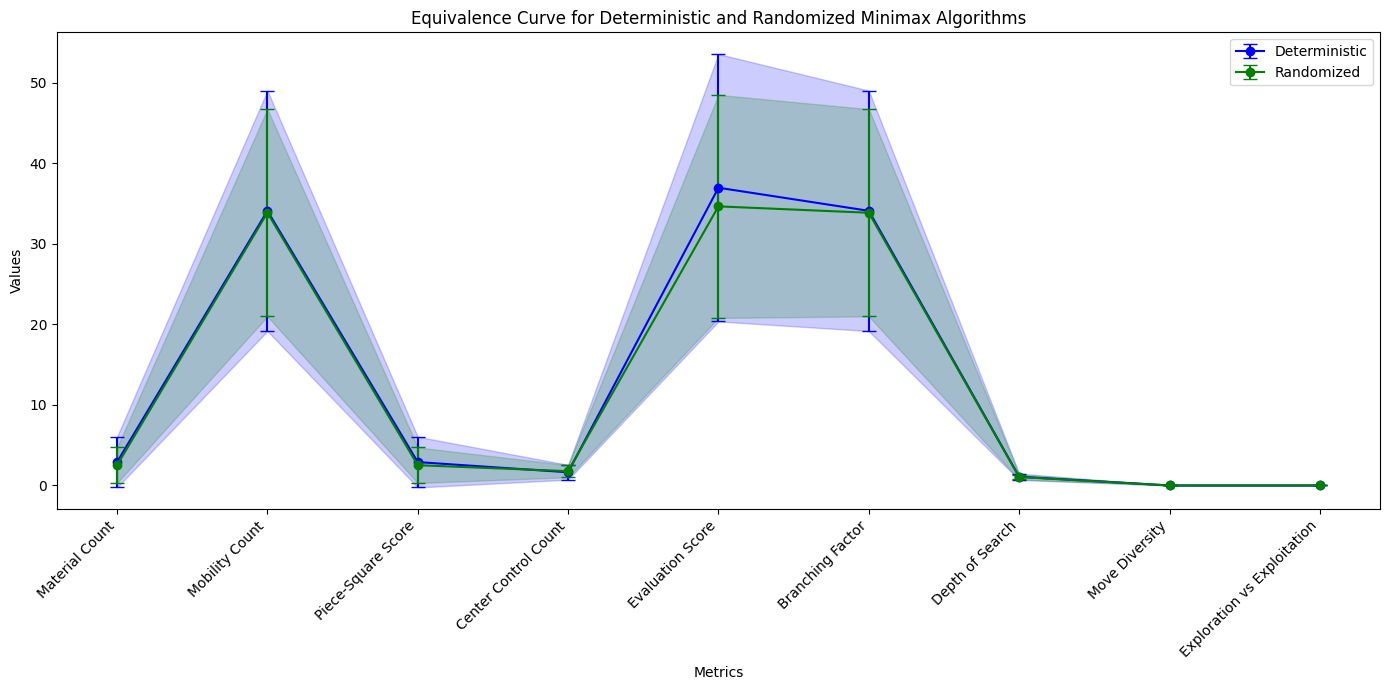

In [ ]:
# Run additional games to gather more data
additional_games = 1
deterministic_results_additional, randomized_results_additional = compare_kane_versions(kane_deterministic, kane_randomized, additional_games)
# Aggregate the additional data
deterministic_mean_additional, deterministic_std_additional, deterministic_data_additional = aggregate_metrics(deterministic_results_additional)
randomized_mean_additional, randomized_std_additional, randomized_data_additional = aggregate_metrics(randomized_results_additional)

# Combine the original and additional data
combined_deterministic_data = pd.concat([deterministic_data, deterministic_data_additional], ignore_index=True)
combined_randomized_data = pd.concat([randomized_data, randomized_data_additional], ignore_index=True)

# Recalculate the means and standard deviations
combined_deterministic_mean = combined_deterministic_data.mean()
combined_deterministic_std = combined_deterministic_data.std()
combined_randomized_mean = combined_randomized_data.mean()
combined_randomized_std = combined_randomized_data.std()

# Display the combined metrics
print("Combined Deterministic Mean Metrics:\n", combined_deterministic_mean)
print("Combined Deterministic Std Metrics:\n", combined_deterministic_std)
print("\nCombined Randomized Mean Metrics:\n", combined_randomized_mean)
print("Combined Randomized Std Metrics:\n", combined_randomized_std)

# Equivalence Curve
def plot_equivalence_curve(deterministic_mean, deterministic_std, randomized_mean, randomized_std):
    metrics = deterministic_mean.index
    x = np.arange(len(metrics))

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot deterministic means with error bars for std
    ax.errorbar(x, deterministic_mean, yerr=deterministic_std, fmt='o-', label='Deterministic', color='blue', capsize=5)

    # Plot randomized means with error bars for std
    ax.errorbar(x, randomized_mean, yerr=randomized_std, fmt='o-', label='Randomized', color='green', capsize=5)

    # Fill between for deterministic std
    ax.fill_between(x, deterministic_mean - deterministic_std, deterministic_mean + deterministic_std, color='blue', alpha=0.2)

    # Fill between for randomized std
    ax.fill_between(x, randomized_mean - randomized_std, randomized_mean + randomized_std, color='green', alpha=0.2)

    # Add title and labels
    ax.set_title('Equivalence Curve for Deterministic and Randomized Minimax Algorithms')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')

    # Add legend
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot equivalence curve
plot_equivalence_curve(combined_deterministic_mean, combined_deterministic_std, combined_randomized_mean, combined_randomized_std)


## Step 7: Perform Statistical Tests

/tmp/ipykernel_172/11210335.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_value_t = ttest_ind(deterministic_data[metric], randomized_data[metric], equal_var=False)
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3906: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
Material Count: t-statistic = -1.5491933384829668, p-value (t-test) = 0.1723082967304001
Material Count: f-statistic = 1.3090909090909093, p-value (F-test) = 0.28207648579052763

Mobility Count: t-statistic = -1.0486144485207938, p-value (t-test) = 0.3368409035632627
Mobility Count: f-statistic = 1.1875019518441026, p-value (F-test) = 0.30414993170927707

Piece-Square Score: t-statistic = -1.5491933384829668, p-value (t-test) = 0.1723082967304001
Piece-

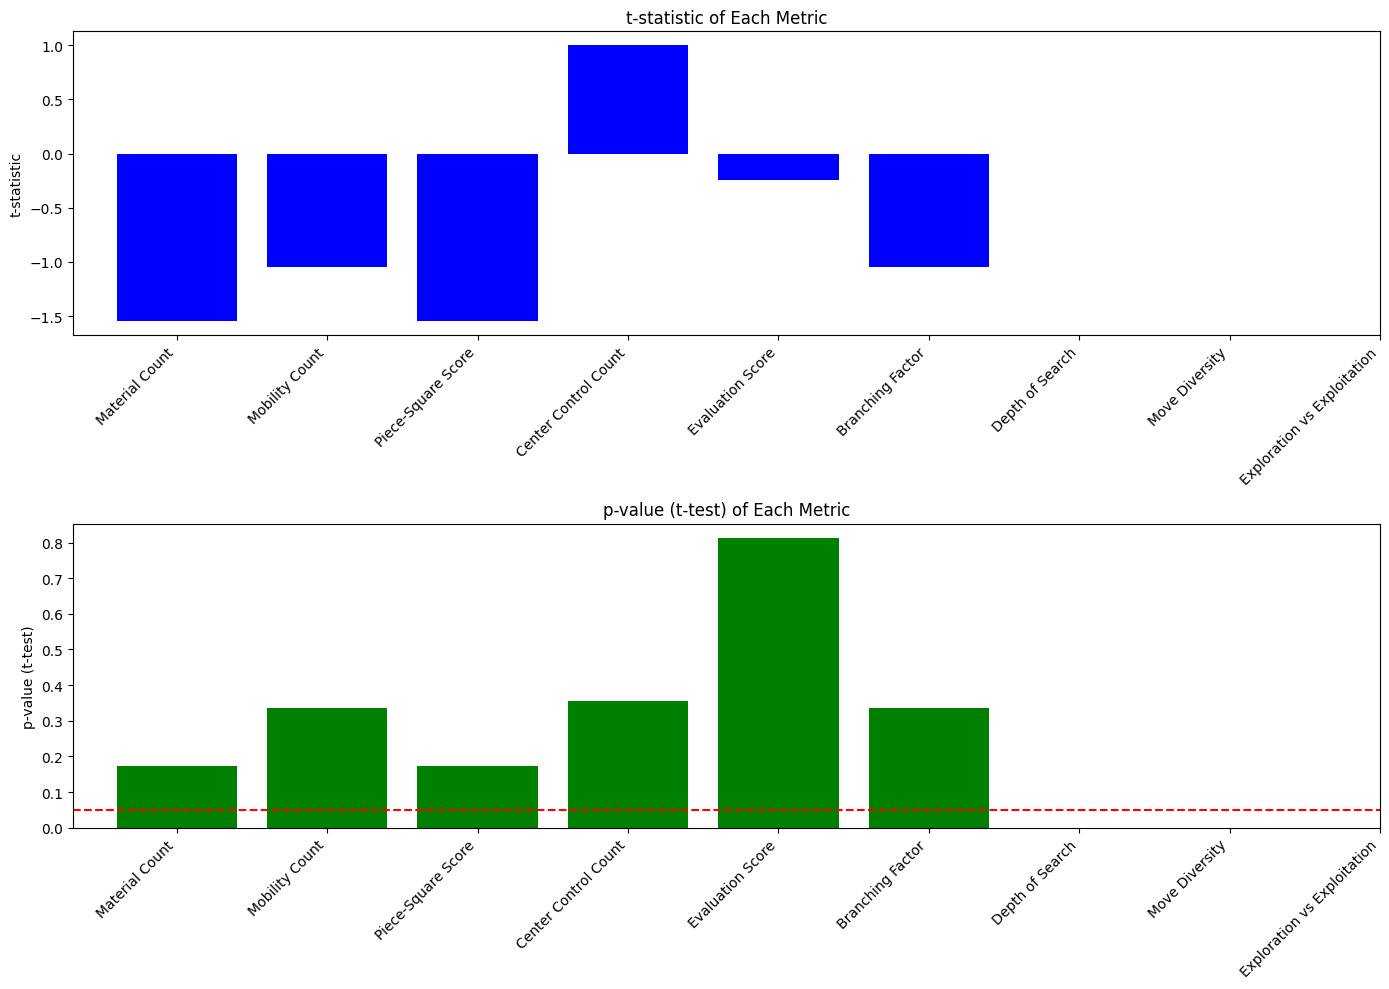

In [ ]:
# Statistical Analysis
from scipy.stats import ttest_ind, f_oneway

# Function to perform statistical tests
def perform_statistical_tests(deterministic_metrics, randomized_metrics):
    results = {}
    for metric in deterministic_metrics.index:
        t_stat, p_value_t = ttest_ind(deterministic_data[metric], randomized_data[metric], equal_var=False)
        f_stat, p_value_f = f_oneway(deterministic_data[metric], randomized_data[metric])
        results[metric] = {
            't_stat': t_stat,
            'p_value_t': p_value_t,
            'f_stat': f_stat,
            'p_value_f': p_value_f
        }
    return results

# Perform statistical tests
statistical_results = perform_statistical_tests(deterministic_mean, randomized_mean)

# Display the results
for metric, result in statistical_results.items():
    print(f"{metric}: t-statistic = {result['t_stat']}, p-value (t-test) = {result['p_value_t']}")
    print(f"{metric}: f-statistic = {result['f_stat']}, p-value (F-test) = {result['p_value_f']}\n")

# Plot statistical analysis results
def plot_statistical_analysis(statistical_results):
    metrics = list(statistical_results.keys())
    t_stats = [result['t_stat'] for result in statistical_results.values()]
    p_values_t = [result['p_value_t'] for result in statistical_results.values()]

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))

    # Plot t-statistics
    axs[0].bar(metrics, t_stats, color='blue')
    axs[0].set_xticks(metrics)
    axs[0].set_xticklabels(metrics, rotation=45, ha='right')
    axs[0].set_ylabel('t-statistic')
    axs[0].set_title('t-statistic of Each Metric')

    # Plot p-values (t-test)
    axs[1].bar(metrics, p_values_t, color='green')
    axs[1].set_xticks(metrics)
    axs[1].set_xticklabels(metrics, rotation=45, ha='right')
    axs[1].axhline(y=0.05, color='r', linestyle='--')
    axs[1].set_ylabel('p-value (t-test)')
    axs[1].set_title('p-value (t-test) of Each Metric')

    plt.tight_layout()
    plt.show()

# Plot statistical analysis results
plot_statistical_analysis(statistical_results)


## Step 8: Integrate KAN Model
### 8.1: Define KAN Model and Training Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from kan import KAN
from sklearn.model_selection import train_test_split
import numpy as np

class CustomKAN(nn.Module):
    def __init__(self, width, grid, k):
        super(CustomKAN, self).__init__()
        width_list = [[w, 0] for w in width]
        self.kan = KAN(width=width_list, grid=grid, k=k)
        self.dropout = nn.Dropout(p=0.5)  # Increased dropout rate
        self.fc1 = nn.Linear(width[-1], 64)  # Reduced layer size
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.kan(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

def normalize_data(data):
    # Avoid division by zero
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1
    return (data - mean) / std

def train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label, num_epochs=5000):
    input_size = train_input.shape[1]
    model = CustomKAN(width=[input_size, 10, 5], grid=3, k=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    train_losses = []
    val_accuracies = []
    test_accuracies = []
    equivalence_scores = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = loss_fn(outputs, train_label.float())
        loss.backward()
        optimizer.step()
        scheduler.step()

        predicted = (outputs >= 0.5).float()
        correct = (predicted == train_label).sum().item()
        train_acc = correct / len(train_label)

        model.eval()
        with torch.no_grad():
            val_outputs = model(val_input)
            val_predicted = (val_outputs >= 0.5).float()
            val_correct = (val_predicted == val_label).sum().item()
            val_acc = val_correct / len(val_label)

            test_outputs = model(test_input)
            test_predicted = (test_outputs >= 0.5).float()
            test_correct = (test_predicted == test_label).sum().item()
            test_acc = test_correct / len(test_label)

        train_losses.append(loss.item())
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        min_length = min(len(train_input), len(test_input))
        f_kan_a = model(train_input[:min_length]).detach().numpy()
        f_kan_b = model(test_input[:min_length]).detach().numpy()
        numerator = np.linalg.norm(f_kan_a - f_kan_b)
        denominator = np.linalg.norm(f_kan_a) + np.linalg.norm(f_kan_b)
        equivalence_score = 1 - (numerator / denominator)
        equivalence_scores.append(equivalence_score)

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}, Equivalence Score: {equivalence_score:.4f}')

    return model, equivalence_scores

### 8.2: Compare Kane Versions and Integrate KAN Model

In [ ]:
def check_data_balance(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

def compare_kane_versions(deterministic_results, randomized_results):
    deterministic_mean, deterministic_std, deterministic_data = aggregate_metrics(deterministic_results)
    randomized_mean, randomized_std, randomized_data = aggregate_metrics(randomized_results)

    # Display the aggregated metrics
    print("Deterministic Mean Metrics:\n", deterministic_mean)
    print("Deterministic Std Metrics:\n", deterministic_std)
    print("\nRandomized Mean Metrics:\n", randomized_mean)
    print("Randomized Std Metrics:\n", randomized_std)

    # Convert to numpy arrays and ensure float type
    deterministic_data = normalize_data(deterministic_data.values.astype(np.float32))
    randomized_data = normalize_data(randomized_data.values.astype(np.float32))
    train_label = np.ones(len(deterministic_data))
    test_label = np.zeros(len(randomized_data))

    # Split the data into training, validation, and test sets
    train_input, val_input, train_label, val_label = train_test_split(deterministic_data, train_label, test_size=0.2, random_state=42)
    test_input, test_label = torch.from_numpy(randomized_data), torch.from_numpy(test_label)

    # Convert to torch tensors
    train_input, val_input = torch.from_numpy(train_input), torch.from_numpy(val_input)
    train_label, val_label = torch.from_numpy(train_label), torch.from_numpy(val_label)

    # Print shapes to debug
    print(f"train_input shape: {train_input.shape}, train_label shape: {train_label.shape}")
    print(f"val_input shape: {val_input.shape}, val_label shape: {val_label.shape}")
    print(f"test_input shape: {test_input.shape}, test_label shape: {test_label.shape}")

    # Check data balance
    train_label_balance = check_data_balance(train_label.numpy())
    val_label_balance = check_data_balance(val_label.numpy())
    test_label_balance = check_data_balance(test_label.numpy())
    print("Train label balance:", train_label_balance)
    print("Validation label balance:", val_label_balance)
    print("Test label balance:", test_label_balance)

    kan_model, equivalence_scores = train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label)

    return kan_model, equivalence_scores

# Compare the two versions over multiple games
kan_model, equivalence_scores = compare_kane_versions(deterministic_results, randomized_results)


Aggregated Data Columns:
 Index(['Material Count', 'Mobility Count', 'Piece-Square Score',
       'Center Control Count', 'Evaluation Score', 'Branching Factor',
       'Depth of Search', 'Move Diversity', 'Exploration vs Exploitation'],
      dtype='object')

Aggregated Data Columns:
 Index(['Material Count', 'Mobility Count', 'Piece-Square Score',
       'Center Control Count', 'Evaluation Score', 'Branching Factor',
       'Depth of Search', 'Move Diversity', 'Exploration vs Exploitation'],
      dtype='object')
Deterministic Mean Metrics:
 Material Count                 -0.10
Mobility Count                 25.95
Piece-Square Score             -0.10
Center Control Count            0.80
Evaluation Score               22.15
Branching Factor               25.95
Depth of Search                 3.00
Move Diversity                  0.00
Exploration vs Exploitation     0.00
dtype: float64
Deterministic Std Metrics:
 Material Count                  0.307794
Mobility Count                  

## Step 9: Visualize Results
### 9.1: Visualize Dataset and Extract Results from KAN Model

/tmp/ipykernel_172/3585460709.py:11: RuntimeWarning: invalid value encountered in divide
  normalized_data = (data - mean) / std


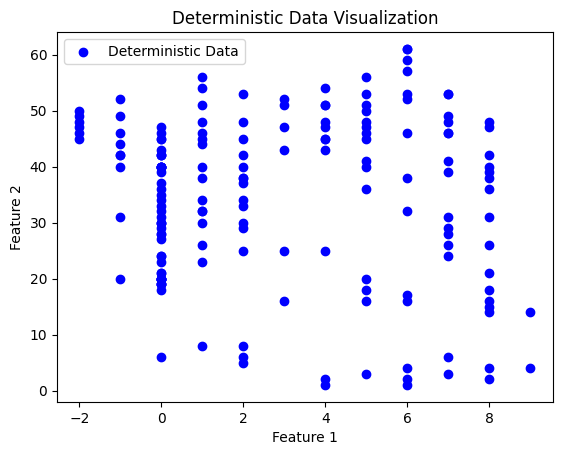

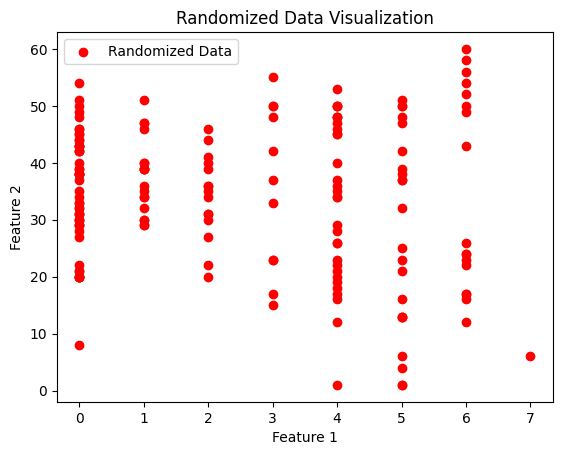

Symbolic Formula: ([0, 0, 0, 0, 0], [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9])


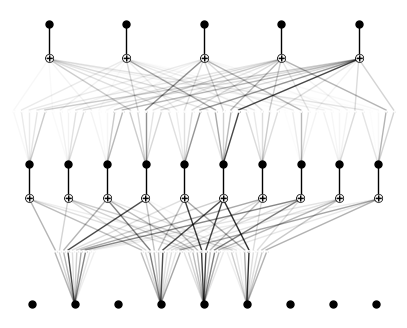

Train Predictions Shape: (137,)
Test Predictions Shape: (169,)
Train Predictions: [17.807907  18.326021  17.999846  12.564174  11.107577  12.534845
 11.054289  16.318098  17.193428  10.420479  16.569687  15.954452
 14.546478  12.753489  13.171307  14.518223  12.93927   18.081284
 12.546677  12.634247  17.12444   17.243963  11.117191  18.491734
 10.8422785 12.763614  11.38121   12.492468  15.553018  17.741428
 11.107753  16.643091  12.089343  10.719218  12.000216  10.423549
  8.872911  10.1924095 11.609337  17.761187  17.42241   10.128194
 17.368752  16.188797  14.903252  17.417828  12.524095  14.227371
 12.387686  13.666315  12.797592  12.57831   13.8206625  8.88829
 17.916857  12.708119  13.115657  17.160742  17.347645  11.959532
 15.016638  16.20246   11.063356  12.937975  16.022594  10.74819
 14.676294  14.815769  10.420479  17.031355   9.591091  18.478172
 17.997993  12.870609  11.44364   15.56816   12.410664  12.080408
 14.13825   14.436722  12.2956085 12.59602   17.769844  16.925

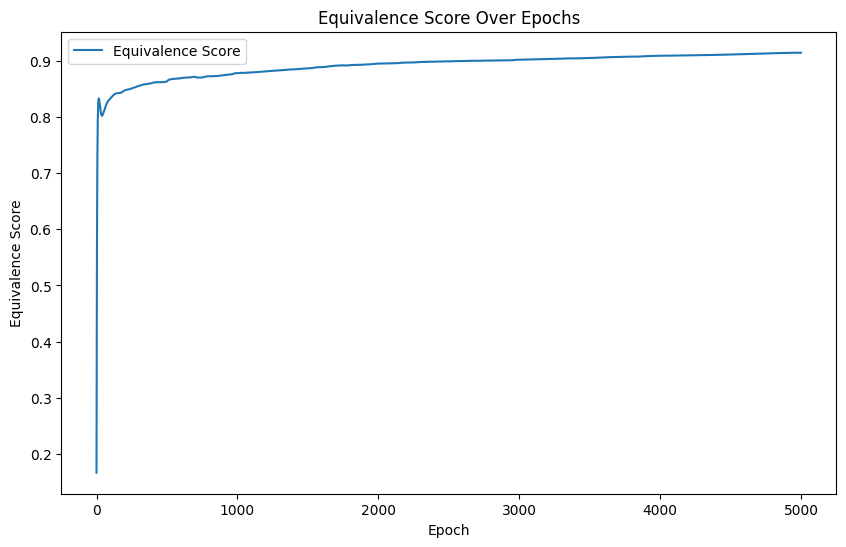

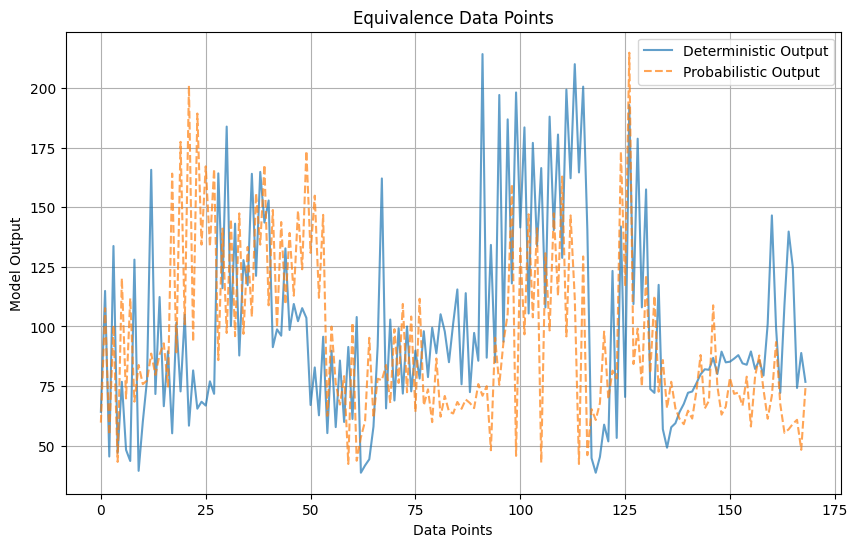

Available keys in the model's state dictionary: ['node_bias_0', 'node_scale_0', 'subnode_bias_0', 'subnode_scale_0', 'node_bias_1', 'node_scale_1', 'subnode_bias_1', 'subnode_scale_1', 'act_fun.0.grid', 'act_fun.0.coef', 'act_fun.0.scale_base', 'act_fun.0.scale_sp', 'act_fun.0.mask', 'act_fun.1.grid', 'act_fun.1.coef', 'act_fun.1.scale_base', 'act_fun.1.scale_sp', 'act_fun.1.mask', 'symbolic_fun.0.mask', 'symbolic_fun.0.affine', 'symbolic_fun.1.mask', 'symbolic_fun.1.affine']


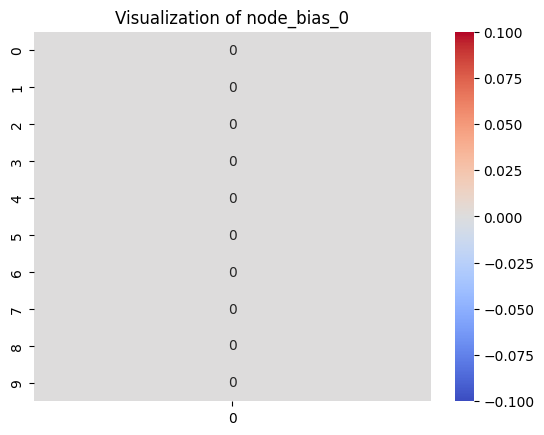

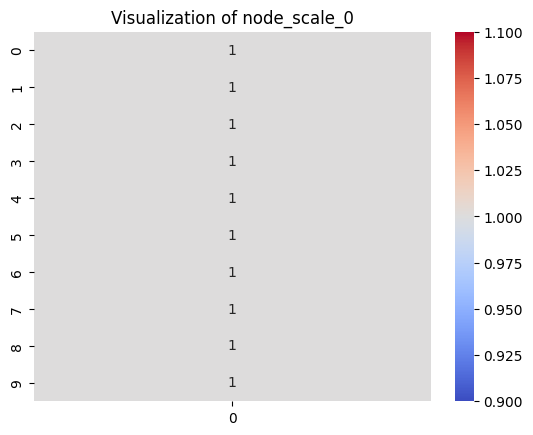

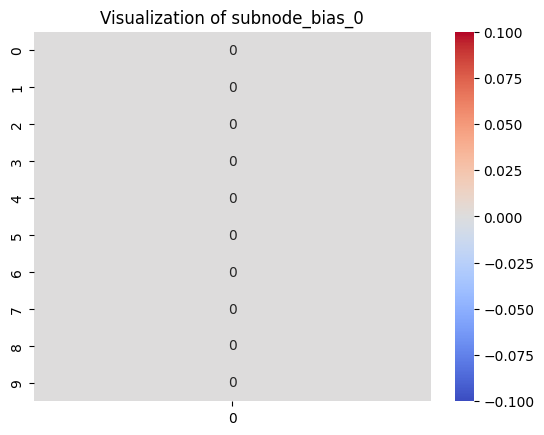

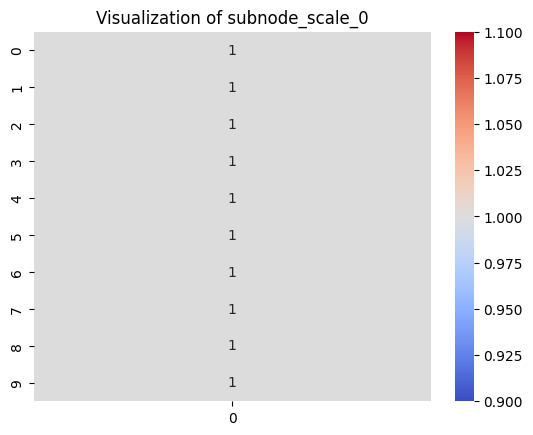

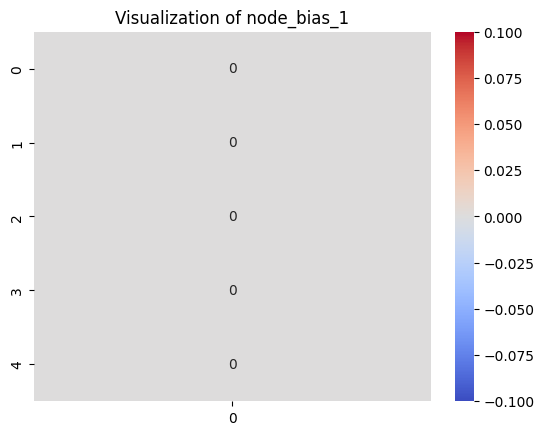

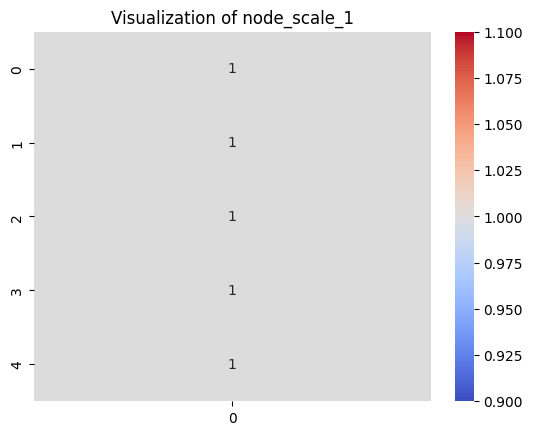

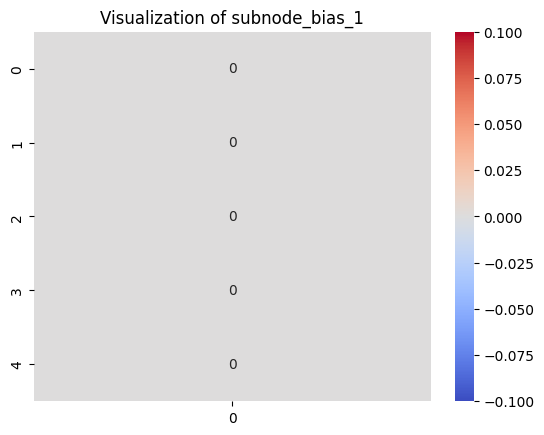

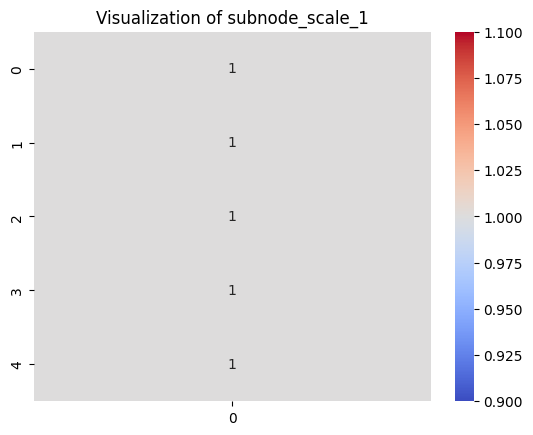

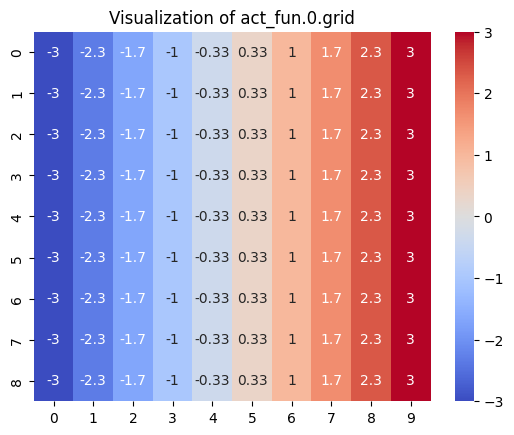

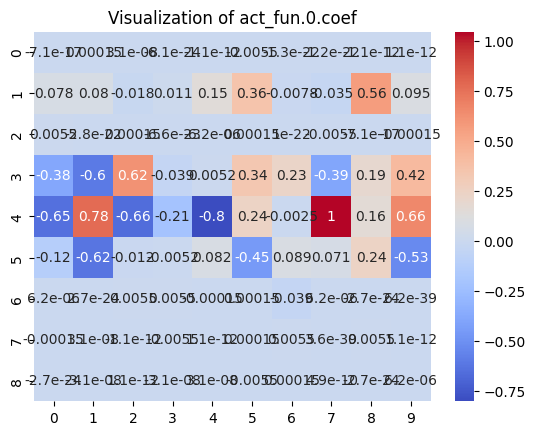

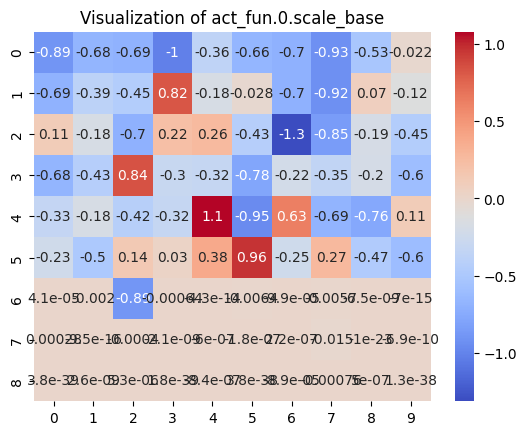

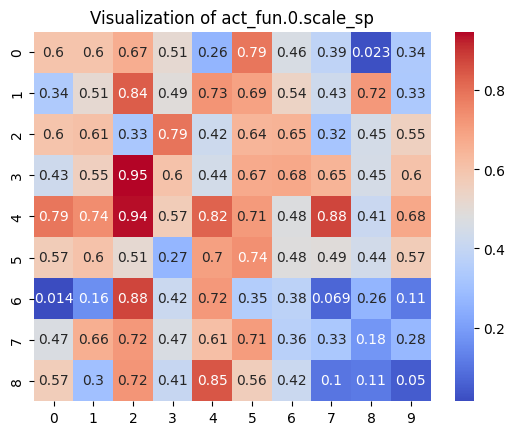

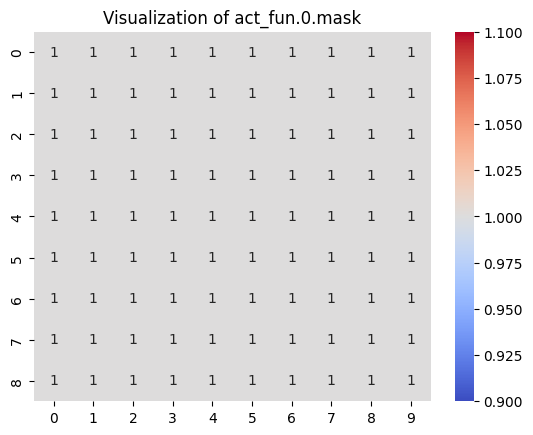

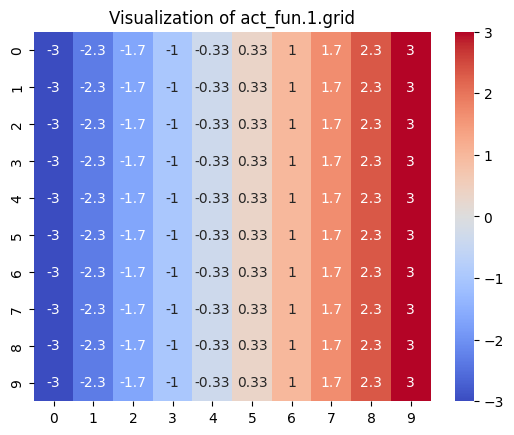

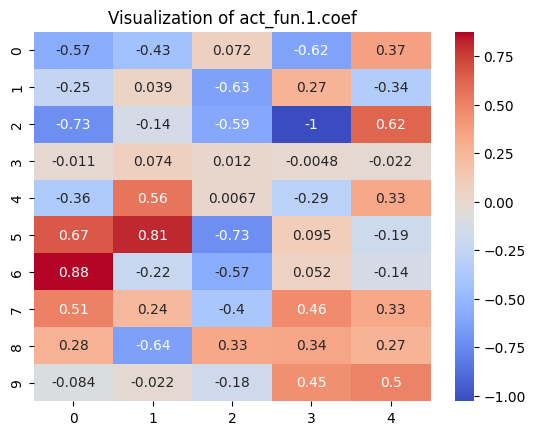

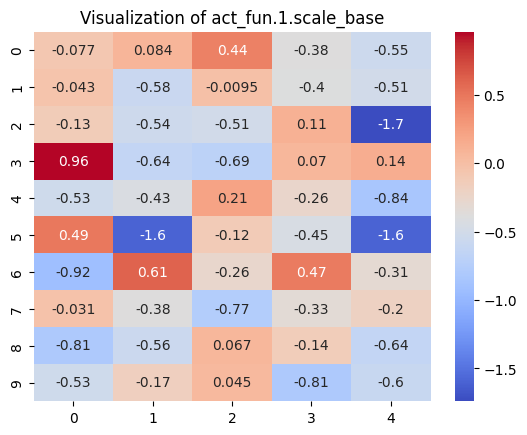

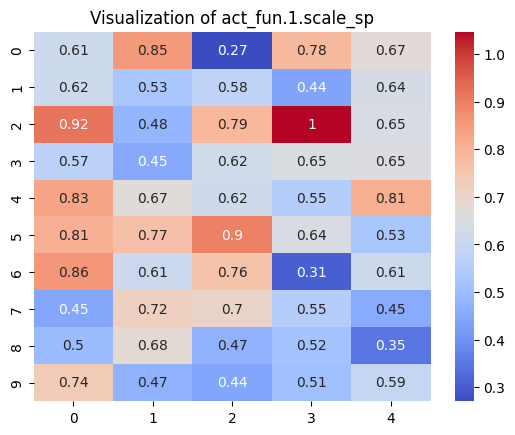

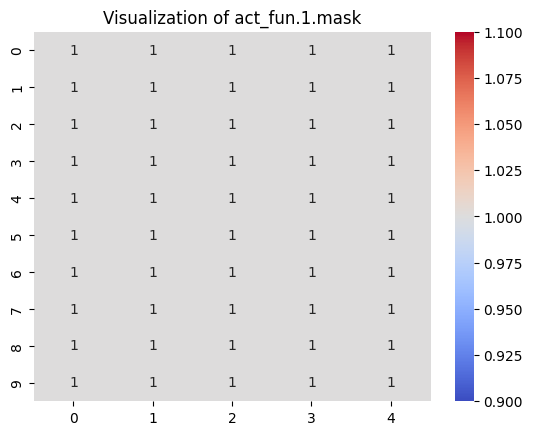

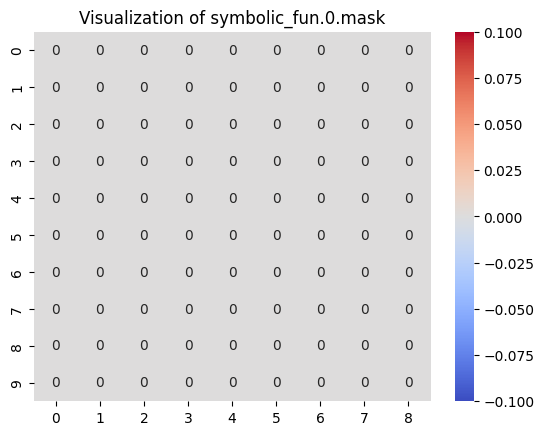

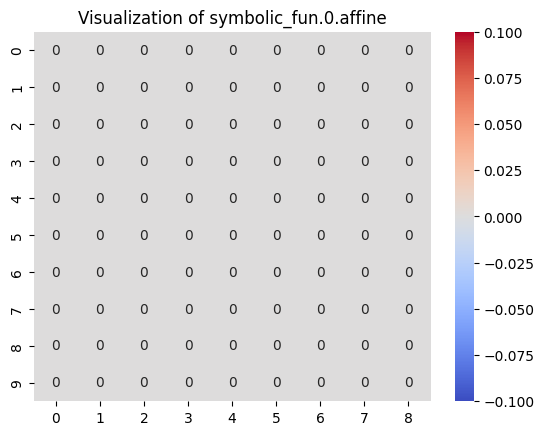

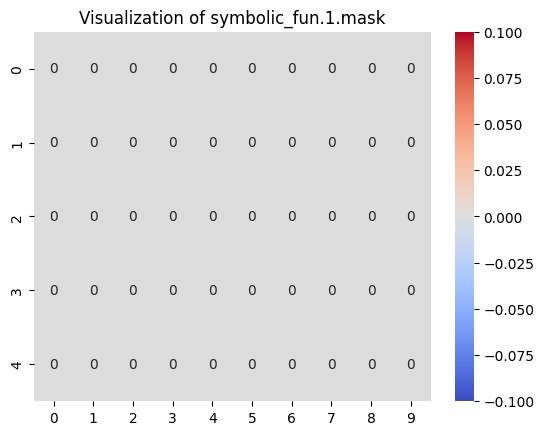

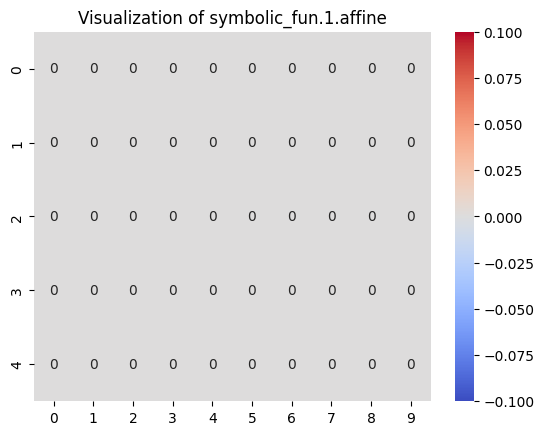

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Normalize the data and handle NaNs
def normalize_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    normalized_data = (data - mean) / std
    normalized_data = np.nan_to_num(normalized_data)  # Replace NaNs with 0
    return normalized_data

# Ensure train_input and test_input are defined
train_input = torch.from_numpy(normalize_data(combined_deterministic_data.values.astype(np.float32)))
test_input = torch.from_numpy(normalize_data(combined_randomized_data.values.astype(np.float32)))
train_label = torch.from_numpy(np.ones(len(train_input))).float()
test_label = torch.from_numpy(np.zeros(len(test_input))).float()

# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split
train_input, val_input, train_label, val_label = train_test_split(train_input.numpy(), train_label.numpy(), test_size=0.2, random_state=42)

# Convert back to torch tensors
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
train_label = torch.from_numpy(train_label)
val_label = torch.from_numpy(val_label)

# Visualize the deterministic dataset
plt.scatter(combined_deterministic_data.iloc[:, 0], combined_deterministic_data.iloc[:, 1], c='blue', label='Deterministic Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Deterministic Data Visualization')
plt.legend()
plt.show()

# Visualize the randomized dataset
plt.scatter(combined_randomized_data.iloc[:, 0], combined_randomized_data.iloc[:, 1], c='red', label='Randomized Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Randomized Data Visualization')
plt.legend()
plt.show()

# Ensure the required image is in place for plotting
img_src_path = '/work/pykan/kan/assets/img/sum_symbol.png'
img_dest_path = '/root/venv/lib/python3.9/site-packages/kan/assets/img/sum_symbol.png'
if not os.path.exists(img_dest_path):
    os.makedirs(os.path.dirname(img_dest_path), exist_ok=True)
    os.system(f'cp {img_src_path} {img_dest_path}')

# Extract symbolic formula
symbolic_formula = kan_model.kan.symbolic_formula()
print(f'Symbolic Formula: {symbolic_formula}')

# Plot model structure
try:
    kan_model.kan.plot()
    plt.show()
except FileNotFoundError as e:
    print(f"Error plotting model: {e}")
except ValueError as e:
    print(f"Value error while plotting model: {e}")

# Prepare data for plotting
train_predictions = kan_model(train_input.float()).detach().numpy()
test_predictions = kan_model(test_input.float()).detach().numpy()

# Print the shapes and values of predictions to debug
print("Train Predictions Shape:", train_predictions.shape)
print("Test Predictions Shape:", test_predictions.shape)
print("Train Predictions:", train_predictions)
print("Test Predictions:", test_predictions)

# Plot equivalence score
plt.figure(figsize=(10, 6))
plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score')
plt.xlabel('Epoch')
plt.ylabel('Equivalence Score')
plt.title('Equivalence Score Over Epochs')
plt.legend()
plt.savefig('equivalence_curve.png')
plt.show()

# Ensure that deterministic_data and randomized_data are converted to numpy arrays
deterministic_data_array = combined_deterministic_data.values.astype(np.float32)
randomized_data_array = combined_randomized_data.values.astype(np.float32)

# Generate a larger set of data points for both deterministic and randomized outputs
deterministic_data_points = kan_model(torch.from_numpy(deterministic_data_array).float()).detach().numpy()
randomized_data_points = kan_model(torch.from_numpy(randomized_data_array).float()).detach().numpy()

# Flatten the outputs to match the number of data points
deterministic_data_points = deterministic_data_points.flatten()
randomized_data_points = randomized_data_points.flatten()

# Ensure the length of both data sets are the same for plotting
min_length = min(len(deterministic_data_points), len(randomized_data_points))
deterministic_data_points = deterministic_data_points[:min_length]
randomized_data_points = randomized_data_points[:min_length]

# Plot equivalence data points
plt.figure(figsize=(10, 6))
plt.plot(deterministic_data_points, label='Deterministic Output', linestyle='-', alpha=0.7)
plt.plot(randomized_data_points, label='Probabilistic Output', linestyle='--', alpha=0.7)
plt.xlabel('Data Points')
plt.ylabel('Model Output')
plt.title('Equivalence Data Points')
plt.legend()
plt.grid(True)
plt.savefig('equivalence_data_points_detailed.png')
plt.show()

# Extract the weights and biases from the trained KAN model
weights = kan_model.kan.state_dict()

# List the available keys
keys = list(weights.keys())
print("Available keys in the model's state dictionary:", keys)

def visualize_weights(key):
    data = weights[key].detach().numpy()
    if data.ndim == 1:
        data = data.reshape(-1, 1)  # Reshape to 2D if it's 1D
    elif data.ndim == 3:
        # For 3D data, we'll visualize the first slice
        data = data[:, :, 0]
    sns.heatmap(data, annot=True, cmap='coolwarm')
    plt.title(f'Visualization of {key}')
    plt.show()

# Visualize the available weights and biases
for key in keys:
    visualize_weights(key)


In [ ]:
def ensure_dataframe(data):
    if isinstance(data, pd.DataFrame):
        return data
    return pd.DataFrame(data)

def compare_versions(deterministic_kane, randomized_kane, games=5, max_moves=55, max_runtime=600):
    deterministic_results = []
    randomized_results = []

    for _ in range(games):
        deterministic_kane.board.reset()
        deterministic_data = play_game_minimax_deterministic(deterministic_kane, max_moves=max_moves, max_runtime=max_runtime)
        deterministic_results.append(deterministic_data)

        randomized_kane.board.reset()
        randomized_data = play_game_minimax_randomized(randomized_kane, max_moves=max_moves, max_runtime=max_runtime)
        randomized_results.append(randomized_data)

    deterministic_results = [ensure_dataframe(df) for df in deterministic_results]
    randomized_results = [ensure_dataframe(df) for df in randomized_results]

    # Define numeric_columns
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']

    combined_deterministic_data = pd.concat(deterministic_results, ignore_index=True)
    combined_randomized_data = pd.concat(randomized_results, ignore_index=True)

    combined_deterministic_normalized = normalize_data(combined_deterministic_data[numeric_columns].values)
    combined_randomized_normalized = normalize_data(combined_randomized_data[numeric_columns].values)

    # Ensure input dimensions match expected KAN model input
    input_dim = combined_deterministic_normalized.shape[1]
    train_input, val_input, train_label, val_label = train_test_split(
        combined_deterministic_normalized, np.ones(len(combined_deterministic_normalized)), test_size=0.2, random_state=42)
    test_input = combined_randomized_normalized
    test_label = np.zeros(len(test_input))

    train_input = torch.from_numpy(train_input).float()
    val_input = torch.from_numpy(val_input).float()
    test_input = torch.from_numpy(test_input).float()
    train_label = torch.from_numpy(train_label).long()
    val_label = torch.from_numpy(val_label).long()
    test_label = torch.from_numpy(test_label).long()

    kan_model, equivalence_scores = train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label)

    return deterministic_results, randomized_results, kan_model, equivalence_scores

# Compare the two versions over multiple games
deterministic_results, randomized_results, kan_model, equivalence_scores = compare_versions(kane_deterministic, kane_randomized, games=5)


In [ ]:
# Visualize results
def visualize_kan_results(deterministic_results, randomized_results, kan_model, equivalence_scores):
    # Ensure train_input and test_input are defined
    combined_deterministic_data = pd.concat(deterministic_results, ignore_index=True)
    combined_randomized_data = pd.concat(randomized_results, ignore_index=True)

    train_input = torch.from_numpy(normalize_data(combined_deterministic_data.values.astype(np.float32)))
    test_input = torch.from_numpy(normalize_data(combined_randomized_data.values.astype(np.float32)))

    # Visualize the deterministic dataset
    plt.scatter(combined_deterministic_data.iloc[:, 0], combined_deterministic_data.iloc[:, 1], c='blue', label='Deterministic Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Deterministic Data Visualization')
    plt.legend()
    plt.show()

    # Visualize the randomized dataset
    plt.scatter(combined_randomized_data.iloc[:, 0], combined_randomized_data.iloc[:, 1], c='red', label='Randomized Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Randomized Data Visualization')
    plt.legend()
    plt.show()

    # Extract symbolic formula
    symbolic_formula = kan_model.kan.symbolic_formula()
    print(f'Symbolic Formula: {symbolic_formula}')

    # Plot model structure
    try:
        kan_model.kan.plot()
        plt.show()
    except FileNotFoundError as e:
        print(f"Error plotting model: {e}")
    except ValueError as e:
        print(f"Value error while plotting model: {e}")

    # Prepare data for plotting
    train_predictions = kan_model(train_input.float()).detach().numpy()
    test_predictions = kan_model(test_input.float()).detach().numpy()

    # Print the shapes and values of predictions to debug
    print("Train Predictions Shape:", train_predictions.shape)
    print("Test Predictions Shape:", test_predictions.shape)
    print("Train Predictions:", train_predictions)
    print("Test Predictions:", test_predictions)

    # Plot equivalence score
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(equivalence_scores)), equivalence_scores, label='Equivalence Score')
    plt.xlabel('Epoch')
    plt.ylabel('Equivalence Score')
    plt.title('Equivalence Score Over Epochs')
    plt.legend()
    plt.savefig('equivalence_curve.png')
    plt.show()

    # Ensure that deterministic_data and randomized_data are converted to numpy arrays
    deterministic_data_array = combined_deterministic_data.values.astype(np.float32)
    randomized_data_array = combined_randomized_data.values.astype(np.float32)

    # Generate a larger set of data points for both deterministic and randomized outputs
    deterministic_data_points = kan_model(torch.from_numpy(deterministic_data_array).float()).detach().numpy()
    randomized_data_points = kan_model(torch.from_numpy(randomized_data_array).float()).detach().numpy()

    # Flatten the outputs to match the number of data points
    deterministic_data_points = deterministic_data_points.flatten()
    randomized_data_points = randomized_data_points.flatten()

    # Ensure the length of both data sets are the same for plotting
    min_length = min(len(deterministic_data_points), len(randomized_data_points))
    deterministic_data_points = deterministic_data_points[:min_length]
    randomized_data_points = randomized_data_points[:min_length]

    # Plot equivalence data points
    plt.figure(figsize=(10, 6))
    plt.plot(deterministic_data_points, label='Deterministic Output', linestyle='-', alpha=0.7)
    plt.plot(randomized_data_points, label='Probabilistic Output', linestyle='--', alpha=0.7)
    plt.xlabel('Data Points')
    plt.ylabel('Model Output')
    plt.title('Equivalence Data Points')
    plt.legend()
    plt.grid(True)
    plt.savefig('equivalence_data_points_detailed.png')
    plt.show()

    # Extract the weights and biases from the trained KAN model
    weights = kan_model.kan.state_dict()

    # List the available keys
    keys = list(weights.keys())
    print("Available keys in the model's state dictionary:", keys)

    def visualize_weights(key):
        data = weights[key].detach().numpy()
        if data.ndim == 1:
            data = data.reshape(-1, 1)  # Reshape to 2D if it's 1D
        elif data.ndim == 3:
            # For 3D data, we'll visualize the first slice
            data = data[:, :, 0]
        sns.heatmap(data, annot=True, cmap='coolwarm')
        plt.title(f'Visualization of {key}')
        plt.show()

    # Visualize the available weights and biases
    for key in keys:
        visualize_weights(key)

# Visualize the results using the defined function
visualize_kan_results(deterministic_results, randomized_results, kan_model, equivalence_scores)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6f51e1a-d40a-494a-8398-36807e7a81cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>